# Investigate the dataset

In [1]:
from scipy.stats import poisson, expon, norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from math import sqrt

In [2]:
# load the dataset
df = pd.read_csv("email_log.csv")

In [3]:
df.dtypes

DATE    object
TIME    object
dtype: object

In [4]:
# convert the DATE and TIME to DATETIME
df["DATE"] = pd.to_datetime(df["DATE"])
df["TIME"] = pd.to_datetime(df["TIME"])

# Parsing the DateTime

We need to append four attributes to the dataset.

- DAYS passed from 2020-1-1 (the origin)
- HOUR of receipts
- MINUTE of receipt
- SECOND of receipt

In [5]:
# Count of days from from 2020-01-01
START_DAY = pd.to_datetime("2020-01-01")
df["DAY"] = df["DATE"] - pd.to_datetime("2020-01-01")

In [6]:
# recast timedelta to int
df["DAY"] = df["DAY"].dt.days.astype('int64')

In [7]:
# recast TIME.hour to int
df["HOUR"] = df["TIME"].dt.hour.astype('int64')

In [8]:
# recast TIME.mins to int
df["MINUTE"] = df["TIME"].dt.minute.astype('int64')

In [9]:
# recast TIME.seconds to int
df["SECOND"] = df["TIME"].dt.second.astype('int64')

## Checking the Poisson process

We need to produce a barplot of each distinct number of emails.

In [10]:
# create a key field to couny
df["key_DD-HH"] = df["DATE"].astype("str") + df["HOUR"].astype("str")

In [11]:
# count the number of emails per hour
tmp_count_per_hour = df.groupby(by=["key_DD-HH"]).count()

In [12]:
# count the frequency of each emails received
tmp_count_of_freq = tmp_count_per_hour.groupby(by=["DATE"]).count()

In [13]:
# reset the index
tmp_count_of_freq.reset_index(inplace=True)

In [14]:
# drop columns
tmp_count_of_freq = tmp_count_of_freq[["DATE", "TIME"]]

In [15]:
# rename remaining
tmp_count_of_freq.rename(columns={"DATE": "X", "TIME": "COUNT"}, inplace=True)

In [16]:
# output data
tmp_count_of_freq.to_csv("count_of_freq.csv")

<AxesSubplot:xlabel='X', ylabel='COUNT'>

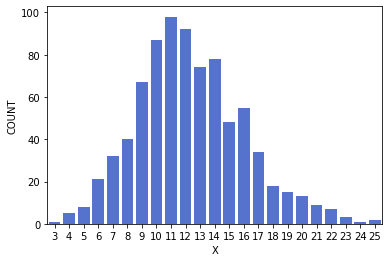

In [17]:
# plot the data
sns.barplot(data=tmp_count_of_freq,
            x="X",
            y="COUNT",
            color="royalblue")

In [18]:
# Get the mean and variance of count of emails
mu_pois = tmp_count_per_hour["HOUR"].mean()
mu_var = tmp_count_per_hour["HOUR"].var()

## Rate of emails is constant

Get the time stamp of each event in HOURS.

- Convert DAY, HOUR, and MIN to seconds
- Sum DAY + HOUR + MIN + SECOND

In [19]:
tmp_rate_emails = pd.DataFrame()

In [20]:
HOURS_PER_DAY = 8  # As this is a work day
tmp_rate_emails["DAY"] = df["DAY"] * HOURS_PER_DAY

In [21]:
# reindex 9.00-17.00 to 00.00-08.00
tmp_rate_emails["HOUR"] = (df["HOUR"] - 1) % 8

In [22]:
HOURS_PER_MINUTE = 1 / 60
tmp_rate_emails["MINUTE"] = df["MINUTE"] * HOURS_PER_MINUTE

In [23]:
HOURS_PER_SECONDS = 1/3600
tmp_rate_emails["SECOND"] = df["SECOND"] * HOURS_PER_SECONDS

In [24]:
# time stamp in seconds
# continuous time from the origin
tmp_rate_emails["TIME STAMP (HH)"] = (tmp_rate_emails["DAY"] +
                                      tmp_rate_emails["HOUR"] +
                                      tmp_rate_emails["MINUTE"] +
                                      tmp_rate_emails["SECOND"])

In [25]:
a_range = np.arange(start=1,
                    stop=tmp_rate_emails["TIME STAMP (HH)"].size+1)

# append a_range to tmp
tmp_rate_emails["EVENT"] = a_range

<AxesSubplot:xlabel='TIME STAMP (HH)', ylabel='EVENT'>

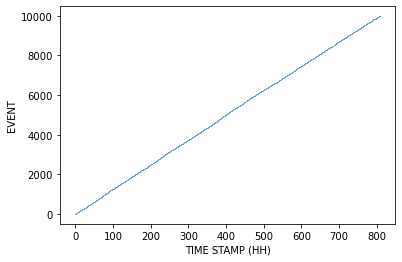

In [26]:
# visualise the dataframe
sns.scatterplot(data=tmp_rate_emails,
                x="TIME STAMP (HH)",
                y="EVENT",
                alpha=1,
                s=1)

## Waiting time between events

Find the timedelta between successive events

In [27]:
tmp_waiting_time = pd.DataFrame()

In [28]:
tmp_waiting_time["TIME STAMP (HH)"] = tmp_rate_emails["TIME STAMP (HH)"]

In [29]:
# shift() shifts the row relative to the row being looked at
tmp_waiting_time["WAITING TIME (HH)"] = (tmp_waiting_time["TIME STAMP (HH)"]-
                                         tmp_waiting_time["TIME STAMP (HH)"].shift(periods=1))

There is a blank waiting time at the first event.
Let us drop this row.

In [30]:
tmp_waiting_time.dropna()

,TIME STAMP (HH),WAITING TIME (HH)
1,0.103889,0.070000
2,0.111944,0.008056
3,0.151389,0.039444
4,0.256667,0.105278
5,0.260278,0.003611
...,...,...
9970,806.938333,0.015278
9971,807.143333,0.205000
9972,807.401111,0.257778
9973,807.600556,0.199444


<AxesSubplot:xlabel='WAITING TIME (HH)', ylabel='Count'>

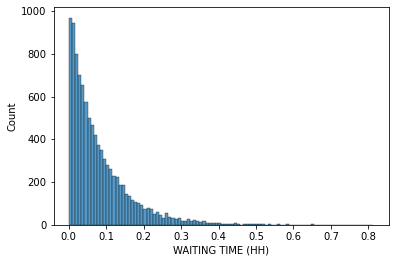

In [31]:
sns.histplot(data=tmp_waiting_time,
             x="WAITING TIME (HH)")

In [32]:
# difference between mean and std
# exponential: mean = std
tmp_waiting_time["WAITING TIME (HH)"].mean()

0.08097344763050597

In [33]:
tmp_waiting_time["WAITING TIME (HH)"].std()

0.0816630944582385

## Estimate $\hat \lambda$

In [34]:
1 / tmp_waiting_time["WAITING TIME (HH)"].mean()

12.34972733979601

## Interval estimate

In [35]:
# declare a normal distribution with mean, var of pois estimate
ci_95 = norm().interval(alpha=0.95)

In [36]:
lower = mu_pois + (ci_95[0] * sqrt(mu_pois / df["DATE"].size))

In [37]:
upper = mu_pois + (ci_95[1] * sqrt(mu_pois / df["DATE"].size))

In [38]:
print("(" + str(lower) + ", " + str(upper) + ")")

(12.276345737338863, 12.41424832206708)
